# **Programa Principal**

In [1]:
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install owid-catalog
# !pip install db-sqlite3
# !pip install SQLAlchemy
# !pip install requests
# !pip install jsonlib

## 1) Bibliotecas

In [2]:
from src import OWID
from utilities import DataFrameTransform
from utilities import Currency
from utilities import DataBaseSQLite3
from utilities import Type
from utilities.DataPlot import DataPlot
import pandas as pd

## 2) Extração de dados da API OWID

### 2.1. Solar photovoltaic capacity:

`Extração de Dados da API OWID`

In [3]:
solar_capacity: OWID = OWID('solar-pv-cumulative-capacity')
pdf_solar_capacity: pd.DataFrame = solar_capacity.slug_into_dataframe()
pdf_solar_capacity

,entities,years,solar_pv_cumulative_capacity
0,United Kingdom,2000,0.002000
1,France,2000,0.007000
2,Netherlands,2000,0.013000
3,Germany,2000,0.114000
4,Switzerland,2000,0.016000
...,...,...,...
4275,Oceania (IRENA),2022,27.396540
4276,Central America and the Caribbean (IRENA),2022,3.986619
4277,North America (IRENA),2022,124.946010
4278,South America (IRENA),2022,32.664700


`Tratamento dos nomes das Colunas`

In [4]:
pdf_solar_capacity: pd.DataFrame = DataFrameTransform.transform_column(pdf_solar_capacity, 'entities', 'País')
pdf_solar_capacity: pd.DataFrame = DataFrameTransform.transform_column(pdf_solar_capacity, 'years', 'Ano')
pdf_solar_capacity: pd.DataFrame = DataFrameTransform.transform_column(pdf_solar_capacity, 'solar_pv_cumulative_capacity', 'Capacidade Acumulada [GW]')
pdf_solar_capacity

,País,Ano,Capacidade Acumulada [GW]
0,United Kingdom,2000,0.002000
1,France,2000,0.007000
2,Netherlands,2000,0.013000
3,Germany,2000,0.114000
4,Switzerland,2000,0.016000
...,...,...,...
4275,Oceania (IRENA),2022,27.396540
4276,Central America and the Caribbean (IRENA),2022,3.986619
4277,North America (IRENA),2022,124.946010
4278,South America (IRENA),2022,32.664700


`Tratamento de Null`

In [5]:
DataFrameTransform.verify_null(pdf_solar_capacity)  #Todas as linhas estão preenchidas. Sem Necessidade de tratamento!

Series([], dtype: int64)

`Tratamento tipos de dados das colunas`

In [6]:
pdf_solar_capacity = DataFrameTransform.transform_type_column(pdf_solar_capacity, 'País', Type.STR) 
pdf_solar_capacity = DataFrameTransform.transform_type_column(pdf_solar_capacity, 'Ano', Type.INT)
pdf_solar_capacity = DataFrameTransform.transform_type_column(pdf_solar_capacity, 'Capacidade Acumulada [GW]', Type.FLOAT)

Coluna País já se encontra com o tipo correto
Coluna Ano já se encontra com o tipo correto
Coluna Capacidade Acumulada [GW] já se encontra com o tipo correto


In [7]:
pdf_solar_capacity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4280 entries, 0 to 4279
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   País                       4280 non-null   object 
 1   Ano                        4280 non-null   int64  
 2   Capacidade Acumulada [GW]  4280 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 100.4+ KB


`Agrupamento por ano no Mundo (todos os países)`

In [8]:
solar_capacity_group_by_year: pd.DataFrame = pdf_solar_capacity.groupby(by=['Ano']).sum()
solar_capacity_group_by_year: pd.DataFrame = solar_capacity_group_by_year.drop(columns='País')
solar_capacity_group_by_year

,Capacidade Acumulada [GW]
Ano,
2000,4.218612
2001,5.744332
2002,7.545161
2003,10.417443
2004,16.548067
2005,24.998977
2006,33.665242
2007,47.488859
2008,84.000952


### 2.2. Solar photovoltaic prices:

`Extração de Dados da API OWID`

In [9]:
solar_prices: OWID = OWID('solar-pv-prices')
pdf_solar_prices: pd.DataFrame = solar_prices.slug_into_dataframe()
pdf_solar_prices

,entities,years,solar_pv_prices
0,World,1975,125.833740
1,World,1976,94.675500
2,World,1977,69.070230
3,World,1978,48.867588
4,World,1979,41.060432
5,World,1980,34.795967
6,World,1981,27.820028
7,World,1982,24.995676
8,World,1983,20.179014
9,World,1984,18.750220


`Conversão de Dólar para Real`

In [10]:
pdf_solar_prices['solar_pv_prices'] = pdf_solar_prices['solar_pv_prices'].map(lambda value: Currency(value).converter())
pdf_solar_prices

,entities,years,solar_pv_prices
0,World,1975,704.52
1,World,1976,530.07
2,World,1977,386.71
3,World,1978,273.60
4,World,1979,229.89
5,World,1980,194.82
6,World,1981,155.76
7,World,1982,139.95
8,World,1983,112.98
9,World,1984,104.98


`Tratamento dos nomes das Colunas`

In [11]:
pdf_solar_prices: pd.DataFrame = pdf_solar_prices.drop(columns='entities') #Todos os dados dessa coluna são 'World' sem necessidade de mantê-la
pdf_solar_prices: pd.DataFrame = DataFrameTransform.transform_column(pdf_solar_prices, 'years', 'Ano')
pdf_solar_prices: pd.DataFrame = DataFrameTransform.transform_column(pdf_solar_prices, 'solar_pv_prices', 'R$/W')
pdf_solar_prices

,Ano,R$/W
0,1975,704.52
1,1976,530.07
2,1977,386.71
3,1978,273.60
4,1979,229.89
5,1980,194.82
6,1981,155.76
7,1982,139.95
8,1983,112.98
9,1984,104.98


`Tratamento de Null`

In [12]:
DataFrameTransform.verify_null(pdf_solar_prices)   #Todas as linhas estão preenchidas. Sem Necessidade de tratamento!

Series([], dtype: int64)

`Tratamento Tipo de Dados`

In [13]:
pdf_solar_prices = DataFrameTransform.transform_type_column(pdf_solar_prices, 'Ano', Type.INT)
pdf_solar_prices = DataFrameTransform.transform_type_column(pdf_solar_prices, 'R$/W', Type.FLOAT)

Coluna Ano já se encontra com o tipo correto
Coluna R$/W já se encontra com o tipo correto


In [14]:
pdf_solar_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ano     48 non-null     int64  
 1   R$/W    48 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 900.0 bytes


### 2.3. Renewable electricity generation

`Extração de dados`

In [15]:
electricity_generation: OWID = OWID('modern-renewable-energy-consumption')
pdf_electricity_generation: pd.DataFrame = electricity_generation.slug_into_dataframe()
pdf_electricity_generation

,entities,years,other_renewables_electricity_generation_twh,solar_electricity_generation_twh,wind_electricity_generation_twh,hydro_electricity_generation_twh
0,Africa,1965,NaN,NaN,0.0000,13.905635
1,Africa,1966,NaN,NaN,0.0000,15.510005
2,Africa,1967,NaN,NaN,0.0000,16.190636
3,Africa,1968,NaN,NaN,0.0000,18.938341
4,Africa,1969,NaN,NaN,0.0000,22.100891
...,...,...,...,...,...,...
5791,World,2019,665.01886,705.46893,1421.3763,4243.124000
5792,World,2020,702.85690,854.92050,1594.6876,4359.410600
5793,World,2021,756.22400,1051.62150,1859.5857,4288.822800
5794,World,2022,776.78250,1321.91400,2107.9631,4323.446000


`Tratamento dos nomes das Colunas`

In [16]:
pdf_electricity_generation: pd.DataFrame = DataFrameTransform.transform_column(pdf_electricity_generation, 'entities', 'País')
pdf_electricity_generation: pd.DataFrame = DataFrameTransform.transform_column(pdf_electricity_generation, 'years', 'Ano')
pdf_electricity_generation: pd.DataFrame = DataFrameTransform.transform_column(pdf_electricity_generation, 'other_renewables_electricity_generation_twh', 'Geração de Outras Energias Renováveis [TWh]')
pdf_electricity_generation: pd.DataFrame = DataFrameTransform.transform_column(pdf_electricity_generation, 'solar_electricity_generation_twh', 'Geração de Energia Solar [TWh]')
pdf_electricity_generation: pd.DataFrame = DataFrameTransform.transform_column(pdf_electricity_generation, 'wind_electricity_generation_twh', 'Geração de Energia Eólica [TWh]')
pdf_electricity_generation: pd.DataFrame = DataFrameTransform.transform_column(pdf_electricity_generation, 'hydro_electricity_generation_twh', 'Geração Energia Hidrelétrica [TWh]')
pdf_electricity_generation

,País,Ano,Geração de Outras Energias Renováveis [TWh],Geração de Energia Solar [TWh],Geração de Energia Eólica [TWh],Geração Energia Hidrelétrica [TWh]
0,Africa,1965,NaN,NaN,0.0000,13.905635
1,Africa,1966,NaN,NaN,0.0000,15.510005
2,Africa,1967,NaN,NaN,0.0000,16.190636
3,Africa,1968,NaN,NaN,0.0000,18.938341
4,Africa,1969,NaN,NaN,0.0000,22.100891
...,...,...,...,...,...,...
5791,World,2019,665.01886,705.46893,1421.3763,4243.124000
5792,World,2020,702.85690,854.92050,1594.6876,4359.410600
5793,World,2021,756.22400,1051.62150,1859.5857,4288.822800
5794,World,2022,776.78250,1321.91400,2107.9631,4323.446000


`Filtro para o Mundo (World)`

In [17]:
pdf_electricity_generation = pdf_electricity_generation[pdf_electricity_generation['País'] == 'World']
pdf_electricity_generation

,País,Ano,Geração de Outras Energias Renováveis [TWh],Geração de Energia Solar [TWh],Geração de Energia Eólica [TWh],Geração Energia Hidrelétrica [TWh]
5737,World,1965,17.985231,0.000000,0.000000,923.19806
5738,World,1966,19.806007,0.000000,0.000000,983.81696
5739,World,1967,19.986570,0.000000,0.000000,1005.74240
5740,World,1968,22.120045,0.000000,0.000000,1059.28870
5741,World,1969,23.257965,0.000000,0.000000,1121.74240
5742,World,1970,25.701897,0.000000,0.000000,1174.64970
5743,World,1971,27.888294,0.000000,0.000000,1227.24220
5744,World,1972,29.888775,0.000000,0.000000,1284.62900
5745,World,1973,32.095850,0.000000,0.000000,1303.01300
5746,World,1974,34.289085,0.000000,0.000000,1431.23170


### 3) Merge Dataframes

`Merge entre os DataFrames 'Solar photovoltaic capacity' e 'Solar photovoltaic prices'`

In [18]:
pdf_solar_merge: pd.DataFrame = DataFrameTransform.merge_tables(solar_capacity_group_by_year, pdf_solar_prices, how='inner', on='Ano')
pdf_solar_merge

,Ano,Capacidade Acumulada [GW],R$/W
0,2000,4.218612,34.57
1,2001,5.744332,33.45
2,2002,7.545161,30.59
3,2003,10.417443,29.08
4,2004,16.548067,24.35
5,2005,24.998977,24.61
6,2006,33.665242,26.82
7,2007,47.488859,27.02
8,2008,84.000952,24.62
9,2009,130.899908,16.46


### 4) Plotagem de Gráficos:

`Gráfico de linha do merge do item anterior`

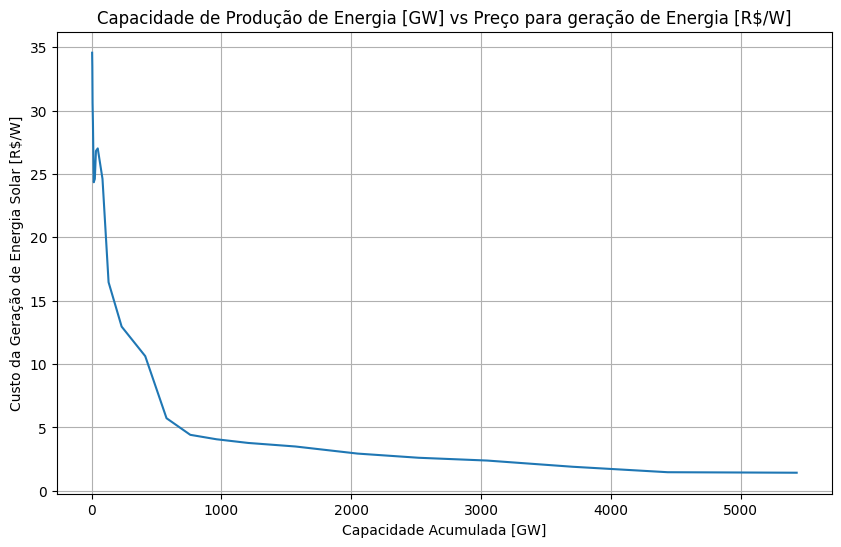

In [19]:
DataPlot.plot_line(data_frame = pdf_solar_merge, 
                   x_col = 'Capacidade Acumulada [GW]',
                   y_col = 'R$/W',
                   title = 'Capacidade de Produção de Energia [GW] vs Preço para geração de Energia [R$/W]',
                   xlabel = 'Capacidade Acumulada [GW]',
                   ylabel = 'Custo da Geração de Energia Solar [R$/W]')


**`Conclusão extraída do Gráfico: `**
<br>
A medida que os anos se passam, a capacidade de geração de Energia Solar aumenta progressimante, e em contrapartida, o preço por Watt gerado diminui consideralvemente.

---

`Gráfico de área com base no Dataframe 'electricity_generation'`

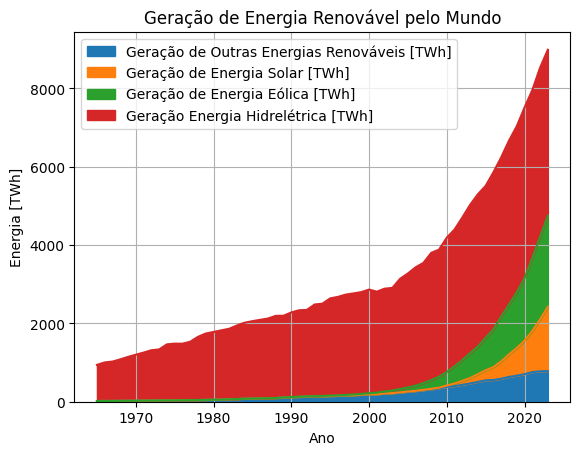

In [20]:
DataPlot.plot_area(data_frame=pdf_electricity_generation,
                   x='Ano',
                   title='Geração de Energia Renovável pelo Mundo',
                   xlabel= 'Ano',
                   ylabel= 'Energia [TWh]')

**`Conclusão extraída do Gráfico: `**
<br>
Embora o custo da geração de energia solar se torna mais acessível com o passar dos anos, ainda assim pelo mundo todo, a maior parte de energia produzida vem das hidrelétricas (curva em vermelho) e do vento (curva em verde).

### 5) Banco de Dados

`Criação do Banco de Dados`

In [21]:
energia_renovavel: DataBaseSQLite3 = DataBaseSQLite3(db_name = 'energia_renovavel3.db')
energia_renovavel.create_database()

Database energia_renovavel3.db formed.
['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__next__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'arraysize', 'close', 'connection', 'description', 'execute', 'executemany', 'executescript', 'fetchall', 'fetchmany', 'fetchone', 'lastrowid', 'row_factory', 'rowcount', 'setinputsizes', 'setoutputsize']


`Enviando o Dataframe da 'Capacidade de Geração vs Custo' para o Banco de Dados`

In [22]:
energia_renovavel.send_dataframe_to_database(
    dataframe = pdf_solar_merge,
    table_name = 'ResumoCapacidadeAnual')

0


`Enviando o DataFrame de 'Geração de eletricidade'`

In [23]:
energia_renovavel.send_dataframe_to_database(
    dataframe = pdf_electricity_generation,
    table_name = 'GeracaoEletricidade'
)

0


`Verificando as Tabelas persistidas no Banco de Dados`

In [24]:
energia_renovavel.check_tables_in_database()

connection.total_changes: 0
tables in database energia_renovavel3.db: [('ResumoCapacidadeAnual',), ('GeracaoEletricidade',)]


`Leitura das tabelas presentes no Banco de Dados`

In [25]:
energia_renovavel.read_table_in_database('ResumoCapacidadeAnual')

[(2000, 4.2186122766888, 34.57),
 (2001, 5.744332050083901, 33.45),
 (2002, 7.545161199845, 30.59),
 (2003, 10.417443404745, 29.08),
 (2004, 16.5480670521644, 24.35),
 (2005, 24.9989772942412, 24.61),
 (2006, 33.6652416931516, 26.82),
 (2007, 47.4888585374277, 27.02),
 (2008, 84.0009518371382, 24.62),
 (2009, 130.8999078817154, 16.46),
 (2010, 231.5279080336727, 12.96),
 (2011, 413.1765033820768, 10.63),
 (2012, 577.2789985202585, 5.73),
 (2013, 760.2778352141751, 4.42),
 (2014, 961.894357334452, 4.07),
 (2015, 1205.743994466278, 3.78),
 (2016, 1569.762341780311, 3.5),
 (2017, 2048.318911776075, 2.94),
 (2018, 2519.2316620769448, 2.61),
 (2019, 3047.24329351924, 2.39)]

In [26]:
energia_renovavel.read_table_in_database('GeracaoEletricidade')

[('World', 1965, 17.985231, 0.0, 0.0, 923.19806),
 ('World', 1966, 19.806007, 0.0, 0.0, 983.81696),
 ('World', 1967, 19.98657, 0.0, 0.0, 1005.7424),
 ('World', 1968, 22.120045, 0.0, 0.0, 1059.2887),
 ('World', 1969, 23.257965, 0.0, 0.0, 1121.7424),
 ('World', 1970, 25.701897, 0.0, 0.0, 1174.6497),
 ('World', 1971, 27.888294, 0.0, 0.0, 1227.2422),
 ('World', 1972, 29.888775, 0.0, 0.0, 1284.629),
 ('World', 1973, 32.09585, 0.0, 0.0, 1303.013),
 ('World', 1974, 34.289085, 0.0, 0.0, 1431.2317),
 ('World', 1975, 34.81208, 0.0, 0.0, 1448.8834),
 ('World', 1976, 38.79105, 0.0, 0.0, 1443.1366),
 ('World', 1977, 40.89204, 0.0, 0.0, 1491.6724),
 ('World', 1978, 43.29665, 0.0, 0.003, 1614.3823),
 ('World', 1979, 46.499256, 0.0, 0.006, 1695.1862),
 ('World', 1980, 49.717464, 0.0, 0.0105, 1731.6493),
 ('World', 1981, 53.48617, 0.0, 0.0105, 1768.9036),
 ('World', 1982, 61.708954, 0.0, 0.0185, 1800.9081),
 ('World', 1983, 68.35493, 0.003, 0.03279495, 1877.7689),
 ('World', 1984, 76.34615, 0.006311111